In [ ]:
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
  from google.colab import drive
  drive.mount('/gdrive')

%matplotlib inline
! pip -q install deeptrack
! pip -q install torchmetrics
! pip -q install einops
! pip -q install torchgeometry

# Set up environment




In [ ]:
import numpy as np

import math, random
from typing import List, Tuple
from scipy.spatial.transform import Rotation as R

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.colors as mcolors

import tensorflow as tf 
import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam

import deeptrack as dt
from deeptrack.extras.radialcenter import radialcenter
from scipy import ndimage
from scipy.stats import expon

import torch
import torch.nn as nn
from torchvision.ops import focal_loss
from torchmetrics import Dice
import torchgeometry as tgm
from torchgeometry.contrib import SpatialSoftArgmax2d
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader

from einops.layers.torch import Reduce

import skimage.io
import cv2 
import itertools
import copy
import os 
import pandas as pd
import glob
import datetime


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {device}')

seed=42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

C:\Users\ga85gik\.conda\envs\toronto\lib\site-packages\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
C:\Users\ga85gik\.conda\envs\toronto\lib\site-packages\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")
C:\Users\ga85gik\.conda\envs\toronto\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on cuda


In [ ]:
if RunningInCOLAB:
  dataset_path = "/gdrive/Shareddrives/Lund_Sim_Project/Unet/test_imgs/"
  model_path = "/gdrive/Shareddrives/Lund_Sim_Project/Unet/chineseChi/SavedModels/"
else:
  dataset_path = "G:/Shared Drives/Lund_Sim_Project/Unet/test_imgs/"
  model_path = "G:/Shared drives/Lund_Sim_Project/Unet/chineseChi/SavedModels/"

enable_logger = False 
doing_training = True
plot_after_every_N_epochs = 2
show_N_demos = 10


load_model_path =  model_path + "vm_training_stage_1_v3_Copy.pt" 
save_model_path =  model_path + "vm_training_stage_2_v3.pt"

project_name = f"virnet_hourglassv3"
architecture = "two-headed hourglass trained on gaussian maps"

print(f"Load model path {load_model_path}")
print(f"Save model path {save_model_path}")
print(f"Do training: {doing_training}")

Load model path G:/Shared drives/Lund_Sim_Project/Unet/chineseChi/SavedModels/vm_training_stage_1_v3_Copy.pt
Save model path G:/Shared drives/Lund_Sim_Project/Unet/chineseChi/SavedModels/vm_training_stage_2_v3.pt
Do training: True


In [ ]:
if enable_logger:
  ! pip install wandb -qU
  import wandb
  wandb.login() # api: f55c493bd6bae39662ce2c065db153aa557091e9

# Simulation configs

In [ ]:
# %% Stimulus parameters
IMAGE_SIZE = (128, 128)#(128, 128)# PUPIL_SIGMA_RANGE[1]*6  # size like in offline example code, set for largest sigma

PUPIL_SIGMA_RANGE = [12, 45]#[12, 45]
PUPIL_SIGMA_RATIO = [1,1.3]#[1, 1.3]
PUPIL_EXP_LOC = 1.
PUPIL_EXP_SCALE = 10.

CR_SIGMA_RANGE = [2, 4]
CR_SIGMA_RATIO = [1, 1.1]
GAUSS_AMPLITUDE_RANGE = [200, 100000] # bunch wider than our testing space
LUMINANCE_RANGE = [.25, .7]         # some augmentation around mid-grey (0.5)
NOISE_SD_RANGE = [0, 30]          # for Gaussian noise

UNIFORM_GAUSSIAN_SIGMA = True   # whether pupil and cr gaussian should have same size in the training labels 

N_CRs = 5
pupil = True # Include pupil or not?

NUM_FEATURES = N_CRs + pupil

# CR constellation configs
MAX_NUM_DUMMIES = 3
DUMMY_SIGMA_RANGE = [2, 4]
DUMMY_SIGMA_RATIO = [1, 2.5]
POLYGON_SIGMA_RANGE = [int(IMAGE_SIZE[0]*0.2), int(IMAGE_SIZE[0]*0.80)] # range location of polygon center 
ROTATION_RANGE = [-35, 35] # rotation of crs as a whole polygon
IRREGULARITY_RANGE = [0.9, .95] # relic of previous polygon function. Recycling it to control the regularity of the polygon 

RECT_HEIGHT_RANGE = [0.6, 0.5] # height should be lower than width, so height will be calculated as a percentage of width
ROOF_HEIGHT_RANGE = [0.2, 0.5] # "
BASE_SQUEEZE_RANGE = [0.09, 0.1] # how narrow is the base of the polygon. Percentage of width   
RECT_WIDTH_RANGE = [IMAGE_SIZE[0]*0.3, IMAGE_SIZE[0]*0.9]

SQUEEZE_RANGE = [0.05, 0.15]

# Random dropout rate
CR_DROPOUT = 0.1 #0.1-0.2 seems to be a reasonable range 

# Invalid value if object is outside the image
INVALID = 0


def get_configs_as_dict():
    return {
        "IMAGE_SIZE" : IMAGE_SIZE,
        "PUPIL_SIGMA_RANGE" : PUPIL_SIGMA_RANGE,
        "PUPIL_EXP_LOC" : PUPIL_EXP_LOC,
        "PUPIL_EXP_SCALE" : PUPIL_EXP_SCALE,
        "CR_SIGMA_RANGE" : CR_SIGMA_RANGE,
        "GAUSS_AMPLITUDE_RANGE" : GAUSS_AMPLITUDE_RANGE,
        "LUMINANCE_RANGE" : LUMINANCE_RANGE,
        "NOISE_SD_RANGE" : NOISE_SD_RANGE,
        "N_CRs" : N_CRs,
        "pupil" : pupil,
        "NUM_FEATURES" : NUM_FEATURES,
        # CR constellation configs
        "MAX_NUM_DUMMIES" : MAX_NUM_DUMMIES,
        "POLYGON_SIGMA_RANGE" : POLYGON_SIGMA_RANGE,
        "ROTATION_RANGE" : ROTATION_RANGE,
        "IRREGULARITY_RANGE" : IRREGULARITY_RANGE,
        "RECT_HEIGHT_RANGE" : RECT_HEIGHT_RANGE,
        "RECT_WIDTH_RANGE" : RECT_WIDTH_RANGE,
        # Random dropout rate
        "CR_DROPOUT" : CR_DROPOUT,
        #"DUMMY_DROPOUT" : DUMMY_DROPOUT,
    }

# Simulation Functions

In [ ]:
# %% Functions
def drawFromRange(range, n=1):
    # range - list of length 2, e.g., [1, 2]
    return range[0] + np.random.rand(n) * np.diff(range)

# inverse unnormalized Gaussian for scaling
def gauss1d_inv(v=0,mx=0,sx=1):
    return mx + np.sqrt(2)*sx*np.sqrt(-np.log(v))

# define 2D Gaussian (without normalization term so peak is 1)
def gauss2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

# define 2D Gaussian (without normalization term so peak is 1)
def gauss2d_oriented(x=0, y=0, mx=0, my=0, sx=1, sy=1, theta=0):
    a = np.cos(theta)**2 / (2 * sx**2) + np.sin(theta)**2 / (2 * sy**2);
    b = np.sin(2 * theta) / (4 * sx**2) - np.sin(2 * theta) / (4 * sy**2);
    c = np.sin(theta)**2 / (2 * sx**2) + np.cos(theta)**2 / (2 * sy**2);
    return np.exp(-(a*(x - mx)**2. + 2.*b*(x - mx)*(y - my) + c*(y - my)**2.))

def positionCRs_noOverlap(sigmas, imsize, prob_surface_params = None):
    if not prob_surface_params:
        prob_surface = lambda x,y: 1
    else:
        # NB: this uses rejection sampling.
        # we want positions near pupil center to be unlikely, specifically, we
        # want the 2D density of the positions to be 1-gauss2d_oriented(<pupil parameters>)
        # so for each point we generate an x and y coordinate, and a probability (0-1)
        # if 1-gauss2d_oriented(x,y)<the generated probability, reject the point
        p_position, p_sigmas, p_ori = prob_surface_params
        prob_surface = lambda x,y: 1-gauss2d_oriented(x,y,p_position[0],p_position[1],1.5*p_sigmas[0],1.5*p_sigmas[1],p_ori)
    sigmas = np.amax(sigmas,1)
    nCR = len(sigmas)
    pos = np.empty((nCR,2,))
    pos[:] = np.nan
    for p in range(nCR):
        ok = False
        while not ok:
            ppos = drawFromRange([sigmas[p],imsize-sigmas[p]],2)
            prob = np.random.rand(1)

            if prob_surface(ppos[0],ppos[1])<prob:
                # reject point due to probability surface
                ok = False
            elif p==0:
                ok = True
            else:
                dists = np.hypot(pos[0:p,0]-ppos[0], pos[0:p,1]-ppos[1])
                ok = all(dists>1.25*(sigmas[0:p]+sigmas[p]))    # 1.25 for little extra space (CRs have tail and even if not we wouldn't want them to touch)
        pos[p,:] = ppos
    return pos

# calculate tail width
def tail_width(v):
    # gauss1d_inv(v/2) / gauss1d_inv(v)
    # i.e., tail width is defined as FWHM of truncated Gaussian
    return np.sqrt(np.log(2)/np.log(v)+1)

# inverse of tail width, so we can sample tails uniformly
def tail_width_inv(w):
    return 2**(1/(w**2 - 1))

# %%Create features
class GrayBackground(dt.Feature):
    # These two are required to make sure that this background can start a pipeline
    __list_merge_strategy__ = dt.MERGE_STRATEGY_APPEND
    __distributed__ = False

    def get(self, image, lum1, lum2, ori, **kwargs):

        x = np.arange(IMAGE_SIZE[0])
        y = np.arange(IMAGE_SIZE[1])
        X, Y = np.meshgrid(y,x)

        mlum = min([lum1,lum2])
        dlum = (max([lum1, lum2])-mlum)/max(IMAGE_SIZE)
        gradient = [np.cos(ori) * dlum, -np.sin(ori) * dlum]
        lum  = X * gradient[0] + Y * gradient[1] + mlum

        return lum*255

class SimpleGaussian(dt.Feature):
    def get(self, image, position, sigma, dropout=False, **kwargs):
        if dropout:
            return image

        x = np.arange(0, image.shape[1])
        y = np.arange(0, image.shape[0])
        x, y = np.meshgrid(x, y)

        # generate
        feature = gauss2d(x,y,mx=position[0], my=position[1], sx=sigma[0], sy=sigma[1])*255
        return np.maximum(image, feature)

class SaturatedGaussian(dt.Feature):
    def _process_properties(self, propertydict):
        if 'CRid' in propertydict:
            CRid = propertydict['CRid']
            if propertydict["dropout"]:
                propertydict['position'] = propertydict[f'cr_position{CRid}'] = np.array([INVALID, INVALID])
            else:
                propertydict['position'] = propertydict[f'cr_position{CRid}'] = propertydict['all_cr_positions'][
                    CRid - 1]

            propertydict['sigma'] = propertydict[f'cr_sigma{CRid}'] = propertydict['all_sigmas'][CRid - 1]
            propertydict[f'gauss_amp{CRid}'] = propertydict['gauss_amp']
            

        if 'DummyId' in propertydict:
            DummyId = propertydict['DummyId']
            if DummyId>=propertydict['all_sigmas'].shape[0]:
                propertydict['dropout'] = True  # we don't want this one
                propertydict['sigma'] = propertydict['position'] = np.nan
            else:
                propertydict['sigma'] = propertydict[f'dummy_sigma{DummyId}'] = propertydict['all_sigmas'][DummyId - 1]
                propertydict['position'] = propertydict[f'dummy_position{DummyId}'] = propertydict['all_dummy_positions'][
                    DummyId - 1]
                propertydict[f'gauss_amp{DummyId}'] = propertydict['gauss_amp']
        
        return super()._process_properties(propertydict)

    def get(self, image, position, sigma, gauss_amp, ori, mode='max', min_val=1., dropout=False, **kwargs):
        if dropout:
            return image

        x = np.arange(0, image.shape[1])
        y = np.arange(0, image.shape[0])
        x, y = np.meshgrid(x, y)
        fac = gauss1d_inv(1 / gauss_amp)
        sd = sigma / fac

        # generate
        feature = gauss_amp*gauss2d_oriented(x,y,mx=position[0], my=position[1], sx=sd[0], sy=sd[1], theta=ori)*255
        if mode=='add':
            return image + feature
        elif mode=='max':
            return np.maximum(image, feature)
        elif mode=='subtract':
            return np.clip(image-feature, min_val, np.inf) # make sure we don't go below min_val

class Discretize(dt.Feature):
    # discretize like a real image, and convert back to float as i'm not sure this library likes uint8 and don't want to try
    def get(self, image, dtype, **kwargs):
        image = image.astype(dtype)
        image = image.astype(np.float64)
        return image

# %%
def get_position(image):
    # Get positions of features
    positions = []
    search_for = ["pupil_position", "CRid"]
    for k in image.properties:
        for key in search_for:
            if key in list(k.keys()):
                position = np.reshape(k['position'],(2,1))
                positions.append(position)

    return np.array(positions).flatten()

def get_label(image):
    def create_mask(dict,type):
        m = GrayBackground().get(None, lum1=0, lum2=0, ori=0)
        m = SimpleGaussian().get(m
                                 , position=dict.get('position')
                                 , sigma=[10,10] if (UNIFORM_GAUSSIAN_SIGMA or type=='CR') else [20,20]
                                 , dropout=dict.get('dropout'))
        m = dt.math.Clip().get(m, min=image.get_property('min'), max=image.get_property('max'))
        m = Discretize().get(m, dtype=np.uint8)
        m = dt.NormalizeMinMax().get(m, 0, 1)

        return  m

    multimask = []

    for k in image.properties:
        if 'pupil_position' in list(k.keys()):
            multimask.append(create_mask(k,'pupil'))
        for i in range(1,N_CRs+1):
            if f'cr_position{i}' in list(k.keys()):
                multimask.append(create_mask(k,'CR'))

    return np.array(multimask)

def get_properties(image):
    props = {
        'pupil_position': image.get_property("pupil_position"),
        'luminance': image.get_property("luminance"),
        'pupil_sigma': image.get_property("pupil_sigma"),
        'pupil_lum': image.get_property("pupil_lum"),
        'position': image.get_property("position")
        }
    for i in range(1,N_CRs+1):
        props[f'cr_position{i}'] = image.get_property(f'cr_position{i}')
        props[f'cr_sigma{i}'] = image.get_property(f'cr_sigma{i}')
        props[f'gauss_amp{i}'] = image.get_property(f'gauss_amp{i}')
    snr = image.get_property("snr")
    if snr:
        props['snr'] = snr
    noise_sigma = image.get_property("noise_sigma")
    if noise_sigma:
        props['noise_sigma'] = noise_sigma
    return props


# Polygon

In [ ]:
def generate_house(length, rect_height, roof_height, center, distortion, rotate_angle: None):

    rect_height = length * rect_height
    roof_height = length * roof_height
    vertices = np.array(create_rectangle(length, rect_height, center)).squeeze()
    vertices = np.array(distort_polygon(vertices, distortion)).squeeze()
    vertices = np.vstack([perpendicular_point(*vertices[-1], *vertices[0], roof_height[0]), vertices])
    vertices = rotate(rotate_angle, center, vertices)

    return vertices


def perpendicular_point(x1, y1, x2, y2, height):
    # length of the base
    base_length = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    # distance between midpoint of base and top of triangle
    hypotenuse = math.sqrt(height ** 2 + (base_length / 2) ** 2)

    # coordinates of the midpoint of the base
    mid_x = (x1 + x2) / 2
    mid_y = (y1 + y2) / 2

    # coordinates of the top point of the triangle
    top_x = mid_x
    top_y = mid_y - height

    return top_x, top_y


def create_rectangle(length, height, center):
    squeeze = length * random.uniform(*BASE_SQUEEZE_RANGE)
    # Calculate the coordinates of the top-left corner of the rectangle
    x = center[0] - length / 2
    y = center[1] - height / 2

    # Create a list of four points representing the corners of the rectangle
    points = [(x + length, y), (x + length - squeeze, y + height), (x + squeeze, y + height), (x, y)]

    return points


def distort_polygon(points, magnitude):
    # Generate a random vector for each point in the polygon
    vectors = [(random.uniform(-1, 1), random.uniform(-1, 1)) for _ in range(len(points))]

    # Calculate the magnitude of each vector
    magnitudes = [magnitude * math.sqrt(v[0] ** 2 + v[1] ** 2) for v in vectors]

    # Normalize the vectors to the desired magnitude
    vectors = [(v[0] / m, v[1] / m) if m > 0 else v for v, m in zip(vectors, magnitudes)]

    # Apply the distortion to each point in the polygon
    distorted_points = [(p[0] + v[0], p[1] + v[1]) for p, v in zip(points, vectors)]

    return distorted_points


def rotate(angle, center, vertices):
    r = R.from_euler('z', angle, degrees=True)
    vertices = np.subtract(np.array(vertices), center)
    vertices = r.apply(np.pad(vertices, (0, 1))[:-1])[:, :-1]
    vertices = np.add(vertices, center)
    return vertices

# Create pipeline 

C:\Users\ga85gik\.conda\envs\toronto\lib\site-packages\deeptrack\math.py:109: RuntimeWarning: invalid value encountered in divide
  image = image / np.ptp(image) * (max - min)


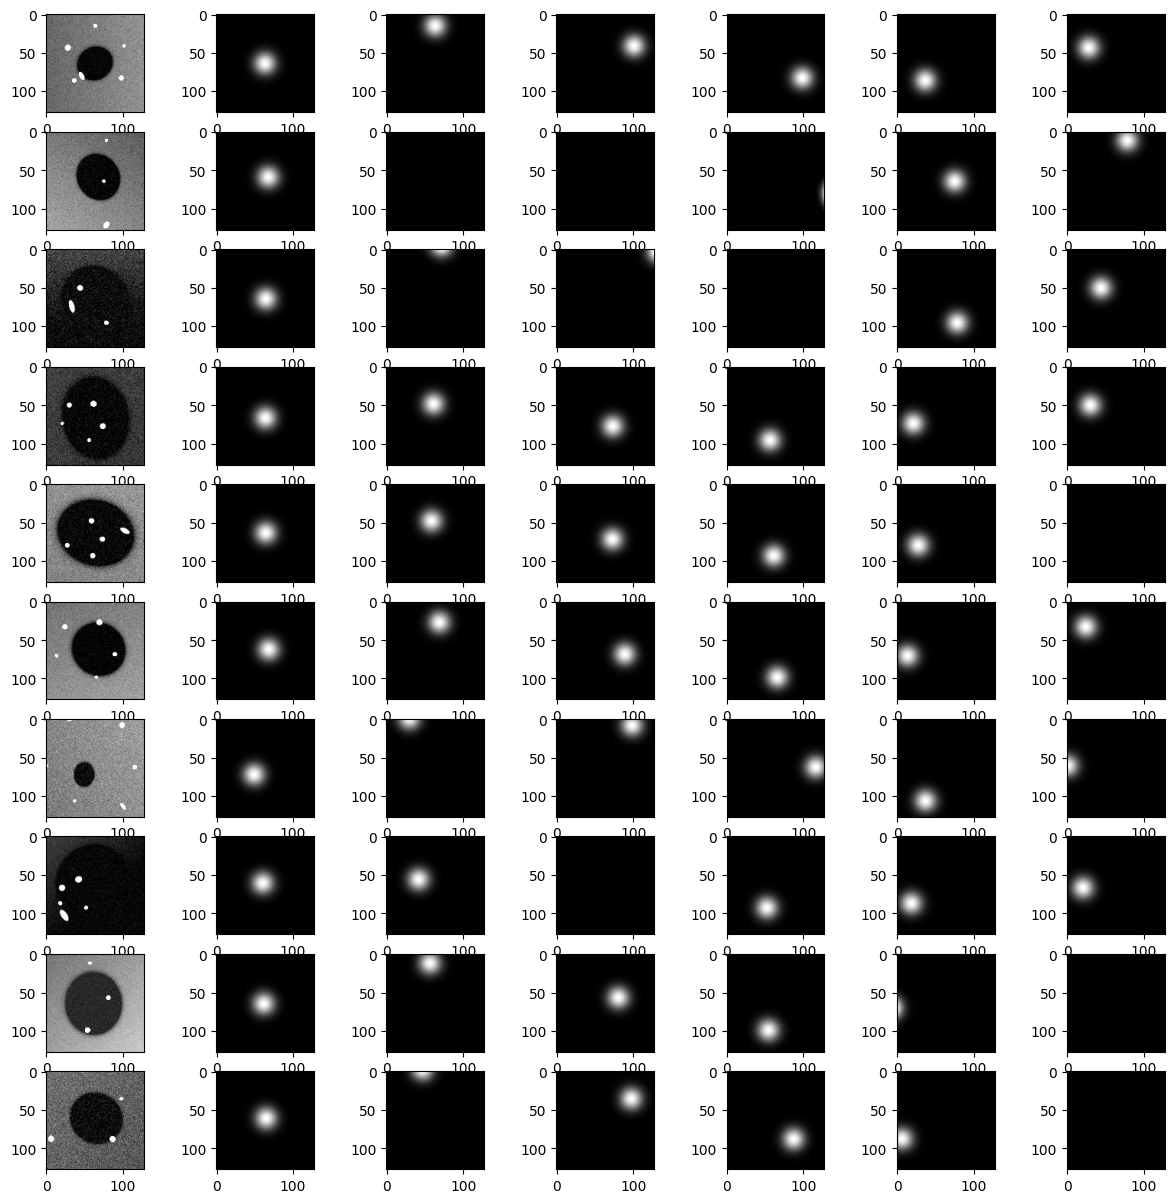

In [ ]:
image_pipeline = GrayBackground(
      lum1=lambda: drawFromRange(LUMINANCE_RANGE),
      lum2=lambda: drawFromRange(LUMINANCE_RANGE),
      ori=lambda: drawFromRange([0, 2*np.pi])
  )

d = 1.1
offset_x = 20
offset_y = 10
CR_NORMAL_STD_X, CR_NORMAL_STD_Y  = 20, 10 

if pupil:
    pupil = SaturatedGaussian(
        pupil_sigma_minor=lambda: drawFromRange(PUPIL_SIGMA_RANGE),
        pupil_sigma_ratio=lambda: drawFromRange(PUPIL_SIGMA_RATIO),
        pupil_sigma=lambda pupil_sigma_minor,pupil_sigma_ratio: pupil_sigma_minor*np.array([1,pupil_sigma_ratio[0]]),
        sigma=lambda pupil_sigma: pupil_sigma,
        # pupil_position=lambda sigma: np.random.rand(2) * (IMAGE_SIZE-2*sigma[0]) + sigma[0], # border of 1 sigma on each side
        max_sigma=lambda sigma: np.max(sigma),
        pupil_position=lambda max_sigma: drawFromRange([max_sigma*d + offset_x,IMAGE_SIZE[0]-max_sigma*d - offset_x],2),
        position=lambda pupil_position: pupil_position,
        gauss_amp=lambda: tail_width_inv(drawFromRange([tail_width(a) for a in GAUSS_AMPLITUDE_RANGE])),#drawFromRange(GAUSS_AMPLITUDE_RANGE),
        ori=lambda: drawFromRange([0, 2*np.pi]),
        mode='subtract',
        pupil_lum=lambda: expon.rvs(loc=PUPIL_EXP_LOC,scale=PUPIL_EXP_SCALE),
        min_val=lambda pupil_lum: pupil_lum
    )

    image_pipeline = image_pipeline >> pupil


def sample_polygon_center(pupil_prop):
    px, py = pupil_prop.get("pupil_position").current_value()
    cr_x, cr_y = np.random.normal(scale=CR_NORMAL_STD_X), np.random.normal(scale=CR_NORMAL_STD_Y)
    cr_x += px
    cr_y += py
    return [cr_x, cr_y]


CR_args = dt.Arguments(
    all_sigma_minors=lambda: drawFromRange(CR_SIGMA_RANGE, N_CRs).reshape((N_CRs,1)),
    all_sigma_ratios=lambda: drawFromRange(CR_SIGMA_RATIO, N_CRs).reshape((N_CRs,1)),
    all_sigmas=lambda all_sigma_minors,all_sigma_ratios: np.multiply(all_sigma_minors, np.hstack((np.ones((N_CRs,1)),all_sigma_ratios))),

    pupil=lambda: pupil.properties,
    star_sigma=lambda: drawFromRange(POLYGON_SIGMA_RANGE),
    star_position=lambda pupil: sample_polygon_center(pupil),

    rotation=lambda: drawFromRange(ROTATION_RANGE),
    irregularity=lambda: drawFromRange(IRREGULARITY_RANGE),

    height=lambda: drawFromRange(RECT_HEIGHT_RANGE),
    roof_height=drawFromRange(ROOF_HEIGHT_RANGE),
    width=lambda: drawFromRange(RECT_WIDTH_RANGE),

    
    all_cr_positions=lambda star_position, irregularity, rotation, height, roof_height, width: generate_house(center= star_position,
                                                                                                 rect_height=height,
                                                                                                 roof_height=roof_height,
                                                                                                 length=width,
                                                                                                 distortion=irregularity,
                                                                                                 rotate_angle=rotation)
    # all_cr_positions=lambda all_sigmas: positionCRs_noOverlap(all_sigmas, IMAGE_SIZE[0])
    )

for CRid in range(1,N_CRs+1):
    image_pipeline >>= SaturatedGaussian(
        CRid=CRid,
        **CR_args.properties,
        gauss_amp=tail_width_inv(drawFromRange([tail_width(a) for a in GAUSS_AMPLITUDE_RANGE])),#drawFromRange(GAUSS_AMPLITUDE_RANGE),
        mode='max',
        ori=lambda: drawFromRange([0, 2*np.pi]),
        dropout = lambda : np.random.uniform() < CR_DROPOUT

    ).bind_arguments(CR_args)


### spurious reflections
dummy_args = dt.Arguments(
    n_dummies=lambda: np.random.randint(0, MAX_NUM_DUMMIES),
    all_sigma_minors=lambda n_dummies: drawFromRange(DUMMY_SIGMA_RANGE, n_dummies).reshape((n_dummies,1)),
    all_sigma_ratios=lambda n_dummies: drawFromRange(DUMMY_SIGMA_RATIO, n_dummies).reshape((n_dummies,1)),
    all_sigmas=lambda all_sigma_minors,all_sigma_ratios,n_dummies: np.multiply(all_sigma_minors, np.hstack((np.ones((n_dummies,1)),all_sigma_ratios))),
    pupil_info=[pupil.position, pupil.sigma, pupil.ori],
    all_dummy_positions=lambda all_sigmas, pupil_info: positionCRs_noOverlap(all_sigmas, IMAGE_SIZE[0], pupil_info)
    )

for DummyId in range(1, MAX_NUM_DUMMIES+1):
    image_pipeline >>= SaturatedGaussian(
        DummyId=DummyId,
        **dummy_args.properties,
        gauss_amp=tail_width_inv(drawFromRange([tail_width(a) for a in GAUSS_AMPLITUDE_RANGE])),#drawFromRange(GAUSS_AMPLITUDE_RANGE),
        mode='max',
        ori=lambda: drawFromRange([0, 2*np.pi]),
        dropout = False
    ).bind_arguments(dummy_args)
###


# create segmented binary masks
# %%
discretizer = Discretize(dtype=np.uint8)

# Generate noise
noise = dt.Gaussian(sigma=lambda: drawFromRange(NOISE_SD_RANGE))#s, background=bg)

# This image has all the properties of the individual images
image_pipeline = image_pipeline >> noise
#
# # Exclude values outside the range [0, 255]
image_pipeline >>= dt.math.Clip(min=0., max=255.)
image_pipeline >>= discretizer
image_pipeline >>= dt.NormalizeMinMax(0,1)

# For Cnn training
label = image_pipeline >> get_position

# For Unet training: separate each object in its own mask
mask_label = image_pipeline >> get_label

unet_pipeline = image_pipeline & mask_label
data_pipeline = image_pipeline & label


if __name__ == '__main__':
    # Testing unet_pipeline (we use this for the unet model which outputs image segmentations)
    # Plots the input image and the prob masks
    n = 10
    fig, axs = plt.subplots(n, NUM_FEATURES + 1, figsize=(15, 15))
    for r in range(n):
        input_image, masks = unet_pipeline.update()()

        if masks.shape[0] > 1:
            for i in range(masks.shape[0]):
                axs[r, i + 1].imshow(masks[i], cmap='gray')
            axs[r, 0].imshow(input_image, cmap='gray')
            pos = get_position(masks).reshape(-1, 2)

            # axs[r, 0].scatter(*pos.T, marker="x")
        else:
            axs.imshow(r, input_image, cmap='gray', vmin=0, vmax=1)
            axs.imshow(r, masks[0], cmap='gray')

    plt.show()

# Build model

In [ ]:
class batchnorm_relu(nn.Module):
    def __init__(self, in_c):
        super().__init__()

        self.bn = nn.BatchNorm2d(in_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.bn(inputs)
        x = self.relu(x)
        return x


class residual_block(nn.Module):
    def __init__(self, in_c, h_c):
        super().__init__()

        """ Convolutional layer """
        self.b1 = batchnorm_relu(in_c)
        self.c1 = nn.Conv2d(in_c, h_c, kernel_size=1)

        self.b2 = batchnorm_relu(h_c)
        self.c2 = nn.Conv2d(h_c, h_c, kernel_size=3, padding="same")

        self.b3 = batchnorm_relu(h_c)
        self.c3 = nn.Conv2d(h_c, in_c, kernel_size=1)

    def forward(self, inputs):
        x = self.b1(inputs)
        x = self.c1(x)

        x = self.b2(x)
        x = self.c2(x)

        x = self.b3(x)
        x = self.c3(x)

        skip = x + inputs
        return skip


class encoder_block(nn.Module):
    def __init__(self, in_c):
        super().__init__()

        self.r = residual_block(in_c, int(in_c // 2))
        self.downsample = nn.MaxPool2d(2)

    def forward(self, inputs):
        skip = self.r(inputs)
        x = self.downsample(skip)

        return x, skip


class decoder_block(nn.Module):
    def __init__(self, in_c):
        super().__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.r = residual_block(in_c, int(in_c // 2))

    def forward(self, inputs, skip):
        x = self.upsample(inputs)
        x = x + skip
        x = self.r(x)
        return x


class build_resunet(nn.Module):
    """
    Hourglass model made of residual blocks based on the chinese CHI paper

    - the hourglass halves the feature map after each layer but keeps the depth the same (64)
    - the residual blocks consist of three convolutions. c(64, 32, 1x1) -> c(32, 32 3x3) -> c(32, 64, 1x1) -> add input to output
    """
    def __init__(self, conv_dims=64, base_dims=64, device="cpu"):
        super().__init__()
        self._device = device

        """ Input """
        self.c0 = nn.Conv2d(1, conv_dims, kernel_size=1)
        self.br0 = batchnorm_relu(conv_dims)

        """ Encoder  """
        self.e1 = encoder_block(conv_dims)
        self.e2 = encoder_block(conv_dims)
        self.e3 = encoder_block(conv_dims)
        self.e4 = encoder_block(conv_dims)
        self.e5 = encoder_block(conv_dims)
        self.e6 = encoder_block(conv_dims)

        """ Bridge """
        self.b1 = residual_block(base_dims, int(base_dims // 2))
        self.b2 = residual_block(base_dims, int(base_dims // 2))
        self.b3 = residual_block(base_dims, int(base_dims // 2))

        """ Decoder """
        self.d_1 = decoder_block(conv_dims)
        self.d0 = decoder_block(conv_dims)
        self.d1 = decoder_block(conv_dims)
        self.d2 = decoder_block(conv_dims)
        self.d3 = decoder_block(conv_dims)
        self.d4 = decoder_block(conv_dims)

        """ Output """

        # CR head
        self.ccr = nn.Conv2d(conv_dims, 5, kernel_size=1)
        self.bcr = nn.BatchNorm2d(5) 

        # Attention
        self.max_pooling_layer = Reduce('b c h w -> b 1 h w', 'max')
        self.avg_pooling_layer = Reduce('b c h w -> b 1 h w', 'mean')
        self.ca = nn.Conv2d(2, 1, kernel_size=7, padding="same")

        # Pupil head
        self.cp = nn.Conv2d(conv_dims, 1, kernel_size=1)
        self.bp = nn.BatchNorm2d(1)

        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, inputs):
        """ Input """
        inp = self.c0(inputs)
        inp = self.br0(inp)

        """ Encoder"""
        x, skip1 = self.e1(inp)
        x, skip2 = self.e2(x)
        x, skip3 = self.e3(x)
        x, skip4 = self.e4(x)
        x, skip5 = self.e5(x)
        x, skip6 = self.e6(x)
      

        """ Bridge """
        b = self.b1(x)
        b = self.b2(b)
        b = self.b3(b)

        """ Decoder """
        d = self.d_1(b, skip6)
        d = self.d1(d, skip5)
        d = self.d1(d, skip4)
        d = self.d2(d, skip3)
        d = self.d3(d, skip2)
        d = self.d4(d, skip1)

        """ output """

        # CR head
        cr = self.ccr(d)
        cr = self.bcr(cr)
        
        # Attention
        max = self.max_pooling_layer(self.relu(cr))
        avg = self.avg_pooling_layer(self.relu(cr))

        attention = torch.cat([max, avg], 1)
        attention = self.ca(attention)
        attention = self.sigmoid(attention)

        # Pupil head
        cp = torch.multiply(attention, d)
        cp = self.cp(cp)
        cp = self.bp(cp)

        return cp, cr

    def predict(self, x, thres=0, centroid_method=None):
        """
        Plan:
        replace sigmoid with relu
        use argmax
        """
        predp, predc = self.forward(x.float().unsqueeze(1).to(self._device))
        predp = self.relu(predp)
        predc = self.relu(predc)

        predp = predp.squeeze(0)
        predc = predc.squeeze(0)

        if predp.dim() == 3:
            pred = torch.cat([predp, predc], 0).cpu().detach()
            pred = pred.unsqueeze(0)
        elif predp.dim() == 4:
            pred = torch.cat([predp, predc], 1).cpu().detach()
        else:
            raise Exception(
                f"Prediction dimension expected to be 3 or 4. Found (pupils){predp.dim()} and (crs){predc.dim()}")

        pred[pred < thres] = 0 # based on results of final model, this step isn't really needed after all 

        b, c, h, w = pred.shape
        pred = pred.reshape(-1, h, w)
        centroids = torch.vstack([(x==torch.max(x)).nonzero()[0].flip(-1) for x in pred])

        return centroids


# Training functions

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction="none"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, pred, target):
        return focal_loss.sigmoid_focal_loss(pred, target, alpha=self.alpha, gamma=self.gamma, reduction=self.reduction)


class DiceLoss(nn.Module):
    """Wrapper for dice """
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.dice = Dice()

    def forward(self, pred, target):
        return 1 - self.dice(pred, target.int())


class BCElogitsWithDiceFocalLoss(nn.Module):
    def __init__(self, weight, alpha=0.25, gamma=2, reduction="none"):
        super(BCElogitsWithDiceFocalLoss, self).__init__()
        self.bceloss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weight))
        self.dice = DiceLoss()
        self.focal = FocalLoss(alpha, gamma, reduction)
        self.sigmoid = nn.Sigmoid()

    def forward(self, pred, target):
        return self.bceloss(pred, target) + self.dice(self.sigmoid(pred), target) + self.focal(pred, target)


class BCElogitsWithDice(nn.Module):
    def __init__(self, weight):
        super(BCElogitsWithDice, self).__init__()
        self.bceloss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weight))
        self.dice = DiceLoss()
        self.sigmoid = nn.Sigmoid()

    def forward(self, pred, target):
        return self.bceloss(pred, target) + self.dice(self.sigmoid(pred), target)


def scaled_pixel_error(P, T):
    return torch.mean(torch.sqrt(torch.sum(torch.square(T - P), axis=-1)))


def pixel_error(P, T):
    return torch.mean(torch.sqrt(torch.sum(torch.square(T - P), axis=-1))) * IMAGE_SIZE[0]


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience.
    https://github.com/Bjarten/early-stopping-pytorch
    """
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        if self.path:
            torch.save(model, self.path)
        self.val_loss_min = val_loss


def train_step(dataloader, model, loss_fn, optimizer, scheduler=None):
    train_loss = 0.0
    model.train()

    try:
        loss_fn_pupil = loss_fn[0]
        loss_fn_cr = loss_fn[1]
    except:
        raise Exception("loss_fn should contain two elements")

    size = len(dataloader) * dataloader.batch_size

    print(f"Dataloader size per epoch: {size}")
    for batch, (X, y) in enumerate(dataloader):
        
        predp, predc = model(X.unsqueeze(1).to(device))

        lossp = loss_fn_pupil(predp.cpu(), y[:, :1])
        lossc = loss_fn_cr(predc.cpu(), y[:, 1:])

        loss = lossc + lossp
    
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), batch * len(X)
        # print(f"\r|   Train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]", end='', flush=True)

        train_loss += loss

    print()

    if scheduler:
        scheduler.step()

    return train_loss / len(dataloader)


def validation_step(dataloader, model, loss_fn):
    
    try:
        loss_fn_pupil = loss_fn[0]
        loss_fn_cr = loss_fn[1]
    except:
        raise Exception("loss_fn should contain two elements")

    validation_loss = 0.0

    size = len(dataloader) * dataloader.batch_size
    print(f"Dataloader size per epoch: {size}")
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            
            predp, predc = model(X.unsqueeze(1).to(device))

            lossp = loss_fn_pupil(predp.cpu(), y[:, :1])
            lossc = loss_fn_cr(predc.cpu(), y[:, 1:])

            loss = lossc + lossp
            
            validation_loss += loss.item()

            print(f"\r|   Val loss: {loss:>7f}", end='', flush=True)

        print()
        return validation_loss / len(dataloader)


def test_step(dataloader, model:build_resunet, dataset_description:str, thres, metrics=None, log_running_metrics=False):
    # using Toronto dataset
    history = {}
    for k in metrics.keys():
        history[k] = []

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            pred = model.predict(X.to(device), thres)
            y = y.reshape(-1, 2)
            pred = pred.nan_to_num(-1)

            if metrics:
                history = log_metrics(pred, y, dataset_description, history, metrics, log_running_metrics)

        for k, v in history.items():
            history[k] = np.mean(v)

    print()
    new_history = {}
    for k, v in history.items():
        new_history[dataset_description + k] = v
    return new_history


def log_metrics(pred, target, dataset_description:str, history:dict, metrics:dict, log_running_metrics:bool):
    for k, v in metrics.items():
        history[k].append(
            v(pred, target)
        )
        if log_running_metrics:
            wandb.log({
                f"batch_{k}": history[k][-1],
                f"epoch_{k}": np.mean(history[k])
            })

        print(f"\r|   Evaluating on {dataset_description}: "
              f"Average {k} : {np.mean(history[k])}", end="", flush=True)

    return history


def visual_demo(dataloader, model, Nrows, Ncols, threshold):

    fig, axs = plt.subplots(Nrows, Ncols)
    axs = axs.ravel()
    for a in axs:
        a.clear()
    cols = list(mcolors.TABLEAU_COLORS.keys())[:NUM_FEATURES]

    i = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            pred = model.predict(X.to(device), threshold)
            pred = pred.nan_to_num(-1)
            pred = pred.reshape(dataloader.batch_size, -1, 2)

            for subject, (img, p, targ) in enumerate(zip(X, pred, y)):
                axs[i].imshow(img, cmap="gray")
                for c_, t_ in enumerate(targ):
                    current_color = cols[c_]
                    axs[i].scatter(*t_, edgecolors=current_color, marker="o", facecolors='none', label={c_+1})
                for c_, p_ in enumerate(p):
                    current_color = cols[c_]
                    axs[i].scatter(*p_, c=current_color, marker="x", label={c_+1})
                i += 1
                if i >= len(axs):
                    break
            if i >= len(axs):
                break
        axs[-1].legend(bbox_to_anchor=(1.1, 1.05))

    plt.show()


def demo_unet(model, loader, device="cpu", up_to_n=5):
    with torch.no_grad():
        for batch, (X, y) in enumerate(loader):
            predp, predc = model(X.unsqueeze(1).float().to(device))

            predp = torch.nn.ReLU()(predp)
            predc = torch.nn.ReLU()(predc)

            # predp = torch.nn.Sigmoid()(predp)
            # predc = torch.nn.Sigmoid()(predc)

            predp = predp.squeeze(0)
            predc = predc.squeeze(0)

            if predp.dim() == 3:
                pred = torch.cat([predp, predc], 0).cpu().detach()
                pred = pred.unsqueeze(0)
            elif predp.dim() == 4:
                pred = torch.cat([predp, predc], 1).cpu().detach()
            else:
                raise Exception(
                    f"Prediction dimension expected to be 3 or 4. Found (pupils){predp.dim()} and (crs){predc.dim()}")

            pred[pred < 0.9] = 0

            b, c, h, w = pred.shape

            centroids = torch.vstack([(x == torch.max(x)).nonzero()[0].flip(-1) for x in pred.reshape(-1, h, w)]).reshape(loader.batch_size, -1, 2)
            fig, axs = plt.subplots(up_to_n, 1 + pred.shape[1])
            cols = list(mcolors.TABLEAU_COLORS.keys())[:NUM_FEATURES]
            for batch, (p, c, img, ax) in enumerate(zip(pred, centroids, X, axs)):
                ax[0].imshow(img, cmap="gray")
                for i, (p_, c_) in enumerate(zip(p, c)):
                    current_color = cols[i]
                    ax[i+1].imshow(p_, cmap="gray")

                    ax[0].scatter(*c_, c=current_color, marker="x")
                    ax[i+1].scatter(*c_, c=current_color, marker="x")

            break

#Prepare Toronto dataset

Loading files: 169/169 from participant/s ['P1']

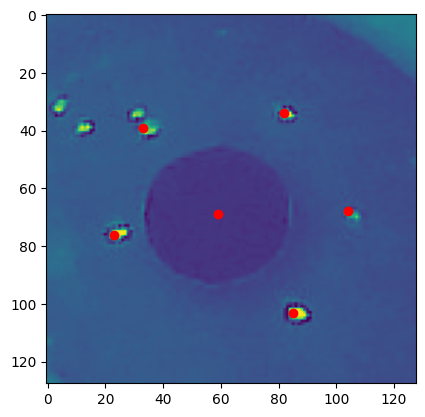

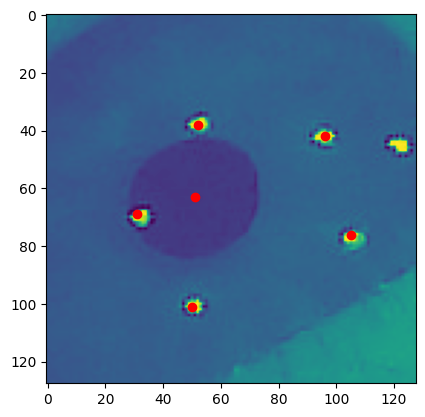

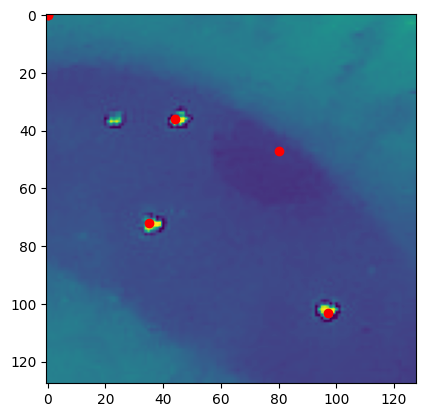

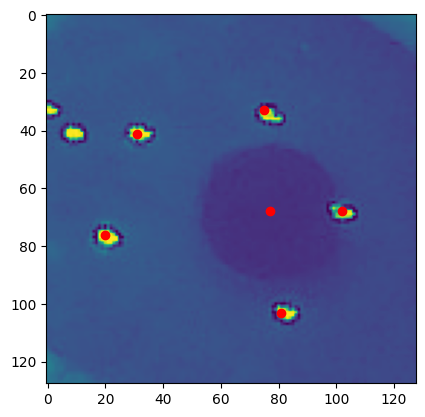

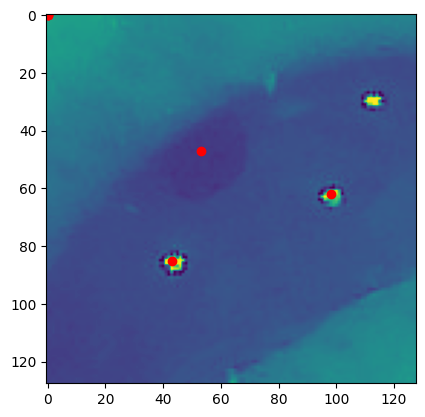

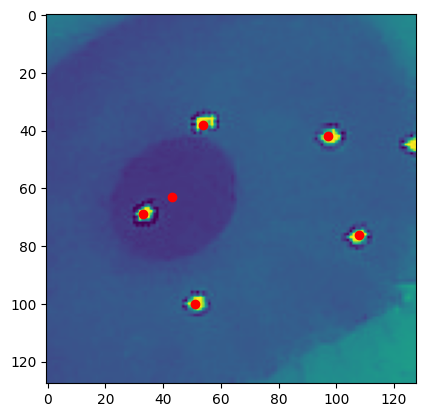

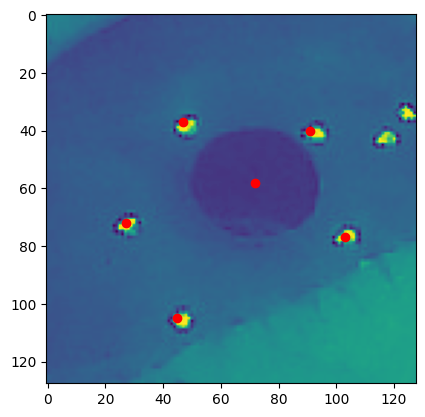

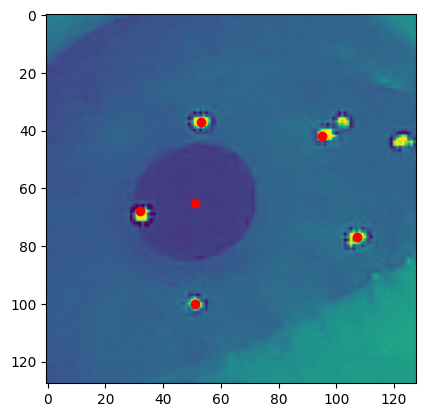

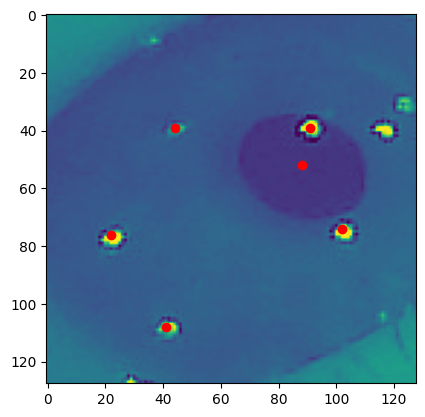

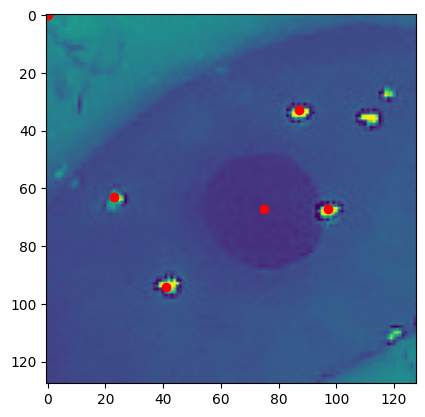

In [ ]:
def crop_from_center(image, w, h, px, py, return_offset=True):
    center = image.shape
    x = px - w/2
    y = py - h/2

    crop_img = image[int(y):int(y+h), int(x):int(x+w)]
    if return_offset:
      return crop_img, x, y
    return crop_img


def retrieve_from(participant, from_dir, only_n_files=None, shuffled=False):
    files = glob.glob(from_dir + participant + "_*")
    if shuffled:
        np.random.shuffle(files)
    if only_n_files:
        return files[:only_n_files]
    else:
        return files


def get_toronto_set(dataset_path, participants=None, n_files=50, shuffled=False):
    """
    Toronto: 640x480 downsampled (random crop) to 320x240
    ChineseChi: full face image cropped to eye region with size 288x192

    We'll stick to square image size
    """
    # Dataset path
    toronto_path = dataset_path + "data/LabelledImages/"
    labels_path = toronto_path + "label.txt"

    labeldf = pd.read_json(labels_path)
    files = []

    if participants:
        for participant in participants:
            all_participant_files = retrieve_from(participant, from_dir=toronto_path, shuffled=shuffled)
            files.extend(all_participant_files)

    else:
        participants = [f"P{i + 1}" for i in range(15)]
        for participant in participants:
            nfiles = retrieve_from(participant, from_dir=toronto_path, only_n_files=n_files, shuffled=shuffled)
            files.extend(nfiles)

    test_labels = []
    test_data = []

    for i, f in enumerate(files):
        print(f"\rLoading files: {i+1}/{len(files)} from participant/s {participants}", end="", flush=True)
        part_ =  f.replace("\\", "/").split('/')[-1]

        px = labeldf[part_]['PupilCenter']['PupilX']
        py = labeldf[part_]['PupilCenter']['PupilY']

        cxs = labeldf[part_]['CornealReflectionLocations']['CornealX']
        cys = labeldf[part_]['CornealReflectionLocations']['CornealY']
        image = cv2.imread(f)

        if image.shape[:2] == (240, 320):
            image = cv2.resize(image, (640,480))
            px *= 2
            py *= 2
            cxs = [c*2 for c in cxs]
            cys = [c*2 for c in cys]

        centerx = int(np.mean([p for p in [px, *cxs] if p >= 0]))
        centery = int(np.mean([p for p in [py, *cys] if p >= 0]))

        image, offX, offY = crop_from_center(image, w=IMAGE_SIZE[1], h=IMAGE_SIZE[0], px=centerx, py=centery, return_offset=True)

        # change color channels form bgr to rgb
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # normalise data
        image = (image/255).astype(np.float64)

        bg = np.zeros(IMAGE_SIZE) + 0.5
        bg[:image.shape[0], :image.shape[1]] = image

        test_data.append(bg)

        l = np.array([
            [px, *cxs],
            [py, *cys]
        ]).T - [offX, offY]

        l[l < 0] = INVALID
        for i, label in enumerate(l):
            if label[0] >= IMAGE_SIZE[0] or label[1] >= IMAGE_SIZE[1]:
                l[i] = np.array([INVALID, INVALID])

        test_labels.append(l)

    return test_data, test_labels


if __name__ == '__main__':

    n = 5
    test_data, test_labels = get_toronto_set(dataset_path, participants=["P1"], shuffled=True)
    
    model = None

    for x, t in zip(test_data[:n], test_labels):
        plt.imshow(x)
        plt.scatter(*((t.reshape(-1, 2).T)), c='red')
        plt.show()

    for x, t in zip(test_data[-n:], test_labels[-n:]):
        plt.imshow(x)
        plt.scatter(*((t.reshape(-1, 2).T)), c='red')
        plt.show()

    if model:
        for x, t in zip(test_data[:n], test_labels):
            # demo_model(model, x, None)
            demo_unet(model, x, None, thres=0.01)

# Load the model from stage 1



In [ ]:
model = torch.load(load_model_path).to(device)

model

build_resunet(
  (c0): Conv2d(1, 256, kernel_size=(1, 1), stride=(1, 1))
  (br0): batchnorm_relu(
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (e1): encoder_block(
    (r): residual_block(
      (b1): batchnorm_relu(
        (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (c1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
      (b2): batchnorm_relu(
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (c2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (b3): batchnorm_relu(
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (c3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, di

# Train model

In [ ]:
num_epochs = 40
batch_size = 8
lr = 1e-3

scheduler_gamma = 0.9
earlystop_tolerance = 30
earlystop_mindelta = 0

focal_alpha, focal_gamma = 1, 2

min_data_size, max_data_size = int(1e3), int(2e3) # for generator memory
weight_pupil, weight_cr = 1, 1 # for bcewlogits

validation_set_size = 400
threshold = 0 # for binary mask ## deprecate

# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

criterion_p = BCElogitsWithDiceFocalLoss(weight_pupil, alpha=focal_alpha, gamma=focal_gamma, reduction="mean")
criterion_cr = BCElogitsWithDiceFocalLoss(weight_cr, alpha=focal_alpha, gamma=focal_gamma, reduction="mean")

earlystopper = EarlyStopping(patience=earlystop_tolerance, verbose=False, delta=earlystop_mindelta, path=None, trace_func=print)

bestsaver = EarlyStopping(patience=earlystop_tolerance, verbose=False, delta=earlystop_mindelta, path=save_model_path, trace_func=print)

scheduler = ExponentialLR(optimizer, gamma=scheduler_gamma)

evaluation_metrics = {
    "PixelError": scaled_pixel_error, # no scaling necessary because the model predicts the actual xy locations. Using the equation in scaled_pixel_error that doesn't multiply by the image size
}

# Preparing dataset for evaluating xy prediction
test_data_sim, test_label_sim = list(zip(*[data_pipeline.update()() for _ in range(validation_set_size)]))
test_data_sim = [torch.tensor(v, dtype=torch.float) for v in test_data_sim]
test_label_sim = [torch.tensor(v) for v in test_label_sim]
test_loader_sim = DataLoader(list(zip(test_data_sim, test_label_sim)), batch_size=batch_size, shuffle=False)

test_data_real, test_labels_real = get_toronto_set(dataset_path, participants=None, shuffled=True, n_files=60)
test_loader_real = DataLoader(list(zip(test_data_real, test_labels_real)), batch_size=batch_size, shuffle=False)

if doing_training:
    print("Starting training...")

    generator = dt.generators.PyTorchContinuousGenerator(
        unet_pipeline,
        batch_size=batch_size,
        min_data_size=min_data_size,
        max_data_size=max_data_size,
        max_epochs_per_sample=1
    )

    validation_set, validation_labels = list(zip(*[unet_pipeline.update()() for _ in range(validation_set_size)]))
    validation_set =  [torch.tensor(v, dtype=torch.float) for v in validation_set]
    validation_labels = [torch.tensor(v) for v in validation_labels]
    validation_loader = DataLoader(list(zip(validation_set, validation_labels)), batch_size=batch_size, shuffle=True)

    with generator:
        for epoch in range(num_epochs):
            print(f"\n| Epoch {epoch+1} / {num_epochs} lr: {scheduler.get_last_lr() if scheduler else lr} =======================")
            
            epoch_train_loss = train_step(generator, model, [criterion_p, criterion_cr], optimizer, scheduler)
            epoch_val_loss = validation_step(validation_loader, model, [criterion_p, criterion_cr])
            
            print(f"|   Epoch Train Loss: {epoch_train_loss} Epoch Validation Loss: {epoch_val_loss}")

            earlystopper(epoch_val_loss, model) # best model is also cached in this step
            if earlystopper.early_stop:
                print("Early stopping")
                break

            if plot_after_every_N_epochs and epoch % plot_after_every_N_epochs == 0:
                ### Evaluating xy prediction performance on simulated and real eye data
                test_metrics_sim = test_step(test_loader_sim, model, "SIM", thres=threshold, metrics=evaluation_metrics, log_running_metrics=False)
                test_metrics_real = test_step(test_loader_real, model, "REAL", thres=threshold, metrics=evaluation_metrics, log_running_metrics=False)
                bestsaver(test_metrics_real["REALPixelError"], model)

                plt.show()

            generator.on_epoch_end()




Loading files: 900/900 from participant/s ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15']Starting training...


C:\Users\ga85gik\.conda\envs\toronto\lib\site-packages\deeptrack\math.py:109: RuntimeWarning: invalid value encountered in divide
  image = image / np.ptp(image) * (max - min)


Generating 1008 / 1000 samples before starting training

| Epoch 1 / 40 lr: [0.001] =======================
Dataloader size per epoch: 1000

Dataloader size per epoch: 400
|   Val loss: 2.210527
|   Epoch Train Loss: 2.236977680206299 Epoch Validation Loss: 2.2084776396994723
|   Evaluating on SIM: Average PixelError : 16.127466606098263
|   Evaluating on REAL: Average PixelError : 18.08491807182335

| Epoch 2 / 40 lr: [0.0009000000000000001] =======================
Dataloader size per epoch: 1000

Dataloader size per epoch: 400
|   Val loss: 2.188831
|   Epoch Train Loss: 2.1988763828277587 Epoch Validation Loss: 2.1931077898318923

| Epoch 3 / 40 lr: [0.0008100000000000001] =======================
Dataloader size per epoch: 1000

Dataloader size per epoch: 400
|   Val loss: 2.186056
|   Epoch Train Loss: 2.1869424228668213 Epoch Validation Loss: 2.1821984314697938
|   Evaluating on SIM: Average PixelError : 14.14216675047854
|   Evaluating on REAL: Average PixelError : 16.28910033914

# Evaluating best model

In [ ]:
# LOADING BEST MODEL
print(f"Loading model: {save_model_path}")
model = torch.load(save_model_path)

## Testing on simulated dataset

In [ ]:
plt.rcParams["figure.figsize"] = (15,10) 
demo_unet(model, test_loader_sim, device)
plt.show()

## Testing on real dataset

In [ ]:
test_data_real, test_labels_real = get_toronto_set(dataset_path, participants=None, n_files=60)
test_loader_real = DataLoader(list(zip(test_data_real, test_labels_real)), batch_size=batch_size, shuffle=True)
test_metrics_real = test_step(test_loader_real, model
                              , thres=threshold
                              , dataset_description="50PAX_"
                              , metrics=evaluation_metrics
                              , log_running_metrics=False)

participants = [f"P{i+1}" for i in range(15)]
test_set = [get_toronto_set(dataset_path, participants=[p]) for p in participants]

for p, (test_data_real, test_labels_real) in enumerate(test_set):
    test_loader_real = DataLoader(list(zip(test_data_real, test_labels_real)), batch_size=batch_size, shuffle=True)

    test_metrics_real = test_step(test_loader_real, model
                                  , thres=threshold
                                  , dataset_description=f"FINALREAL_{p + 1}"
                                  , metrics=evaluation_metrics
                                  , log_running_metrics=False)

for p, (test_data_real, test_labels_real) in enumerate(test_set):
    print(f"==== PARTICIPANT {p + 1} ====")
    visual_demo(test_loader_real, model, 5, 5, threshold)
    demo_unet(model, test_loader_real, device)
    print("============================")

plt.show()